In [1]:
"""Trains a ResNet on the CIFAR10 dataset.

ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf

ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""
import time
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100, cifar10
import numpy as np
import os, sys
import math
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from sklearn.decomposition import PCA
import lid
from lid import LID
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 16
epochs = 150
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
exp_name = 'Aug_resNet_Cifar10_BS%d_epochs%d' % (batch_size, epochs)

In [3]:
# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape,y_train.shape)
# Input image dimensions.
input_shape = x_train.shape[1:]
x_train_ori = x_train
y_train_ori = y_train
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
if subtract_pixel_mean:
    x_train -= x_train_mean
    x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

train_num,test_num = x_train.shape[0],x_test.shape[0]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


(50000, 32, 32, 3) (50000, 1)
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10)


In [5]:
def lr_schedule(epoch):
    #Learning Rate Schedule
    lr = 1e-3
    if epoch >= epochs * 0.9:
        lr *= 0.5e-3
    elif epoch >= epochs * 0.8:
        lr *= 1e-3
    elif epoch >= epochs * 0.6:
        lr *= 1e-2
    elif epoch >= epochs * 0.4:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# base_lr = 1e-6
# max_lr = 1e-3
# step_size = 5

# def lr_schedule_cycle(iterations):
#     cycle = np.floor(1+iterations/(2*step_size))
#     x = np.abs(iterations/step_size - 2*cycle + 1)
#     lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))/float(2**(cycle-1))
#     return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 name = None):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            activation-bn-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
x`
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
iteration=500
from progressbar import ProgressBar
pbar = ProgressBar()
outlier_mask=np.zeros(train_num,dtype=int)
for i in pbar(range(iteration)):
    mask=np.random.choice(train_num,batch_size,True)
    x_batch = x_train[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_idx = np.argwhere(dis>np.percentile(dis,99))
    batch_outlier_mask=mask[dis_idx]
    outlier_mask[batch_outlier_mask]+=1

100% |########################################################################|


In [7]:
print(len(outlier_mask[outlier_mask!=0]))

493


In [8]:
from progressbar import ProgressBar
pbar = ProgressBar()
best_mask=np.zeros(train_num,dtype=int)
for i in pbar(range(iteration)):
    mask=np.random.choice(train_num,batch_size,True)
    x_batch = x_train[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_idx = np.argwhere(dis<np.percentile(dis,10))
    batch_best_mask=mask[dis_idx]
    best_mask[batch_best_mask]+=1

100% |########################################################################|


# batch lid值较大图像

(493,)
[ 6005 24070 19682 14717  9098  5617 11633 44244 35006 18326 18330 22959
 24706 25158 14434 35785  6966 18970  2241 45232 40754 40655 36183 43617
 45914]


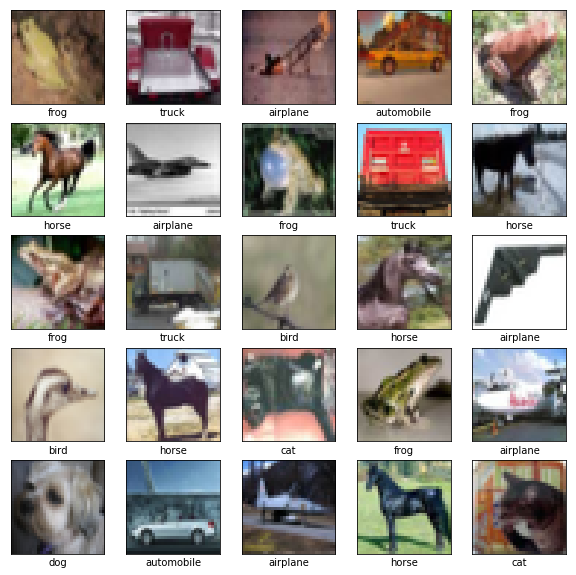

In [9]:
print(np.argwhere(outlier_mask!=0).flatten().shape)
outlier_idx = np.argwhere(outlier_mask!=0).flatten()
random_outlier = np.random.choice(outlier_idx,25,replace=False)
print(random_outlier)
plt.figure(figsize=(10,10))
cifar10_labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_ori[random_outlier[i]], cmap=plt.cm.binary)
    label = np.argwhere(y_train[random_outlier[i]]==1.0).flatten()[0]
    plt.xlabel(cifar10_labels[label])

# batch lid值正常图像

(49507,)
[43857  8884  6393  6747 35195 17915  5808 17990 31064 47394 30670 46832
 13803  1721 36375 28944 15076 20670 27774 17759 18572 28661 16041 17009
 31990]


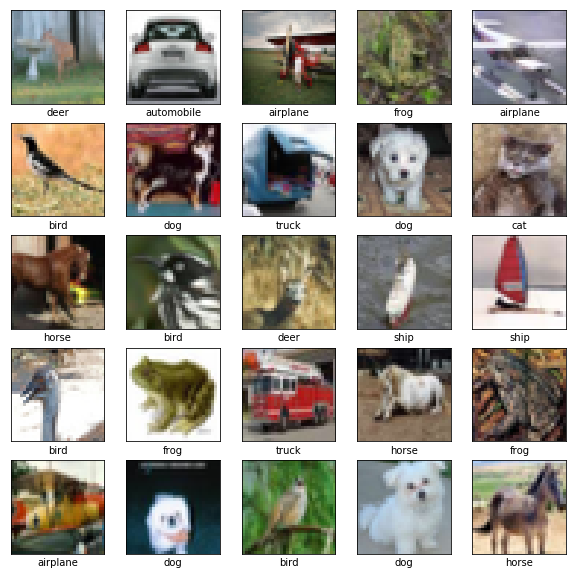

In [10]:
normal_idx = np.argwhere(outlier_mask==0).flatten()
print(normal_idx.shape)
random_normal = np.random.choice(normal_idx,25,replace=False)
print(random_normal)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_ori[random_normal[i]], cmap=plt.cm.binary)
    label = np.argwhere(y_train[random_normal[i]]==1.0).flatten()[0]
    plt.xlabel(cifar10_labels[label])

# batch lid值较小图像

(983,)
[ 6005 24070 19682 14717  9098  5617 11633 44244 35006 18326 18330 22959
 24706 25158 14434 35785  6966 18970  2241 45232 40754 40655 36183 43617
 45914]


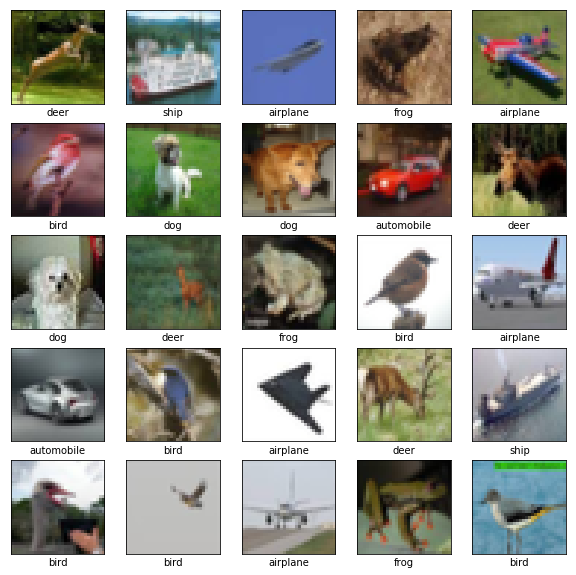

In [11]:
print(np.argwhere(best_mask!=0).flatten().shape)
best_idx = np.argwhere(best_mask!=0).flatten()
random_best = np.random.choice(best_idx,25,replace=False)
print(random_outlier)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_ori[random_best[i]], cmap=plt.cm.binary)
    label = np.argwhere(y_train[random_best[i]]==1.0).flatten()[0]
    plt.xlabel(cifar10_labels[label])

# 以类别为单位的高质量图像（去除cls lid值最高的1%样本，val acc下降6%）

In [12]:
new_x_train = []
new_y_train = []
y_train = np.argmax(y_train,axis=1)
x_val = x_train_ori[:5000]
y_val = y_train[:5000]
x_train = x_train_ori[5000:]
y_train = y_train[5000:]
print(x_val.shape,y_val.shape)
for cls in range(10):
    print('Start class', cls)
    selected_x_val = x_val[y_val==cls]
    selected_x_train = x_train[y_train==cls]
    selected_y_train = y_train[y_train==cls]
    x_train_temp = selected_x_train.reshape(selected_x_train.shape[0],-1)
    k = int(math.sqrt(batch_size))
    from progressbar import ProgressBar
    pbar = ProgressBar()
    for i in range(int(selected_x_train.shape[0]/batch_size)):
        train_temp_batch_mask = np.random.choice(selected_x_train.shape[0],batch_size)
        selected_x_train_batch = selected_x_train[train_temp_batch_mask]
        selected_y_train_batch = selected_y_train[train_temp_batch_mask]
        x_train_temp_batch = x_train_temp[train_temp_batch_mask]
        y_train_temp_batch = selected_y_train[train_temp_batch_mask]
        dis = LID(x_train_temp_batch, x_train_temp_batch, k)  # 也可以和validation计算
        dis_idx = np.argwhere(dis > np.percentile(dis,99)).flatten()    # 选择cls lid最高的1%
        new_x_train.extend(selected_x_train_batch[dis_idx])
        new_y_train.extend(selected_y_train_batch[dis_idx])

(5000, 32, 32, 3) (5000,)
Start class 0
Start class 1
Start class 2
Start class 3
Start class 4
Start class 5
Start class 6
Start class 7
Start class 8
Start class 9


[ 6005 24070 19682 14717  9098  5617 11633 44244 35006 18326 18330 22959
 24706 25158 14434 35785  6966 18970  2241 45232 40754 40655 36183 43617
 45914]


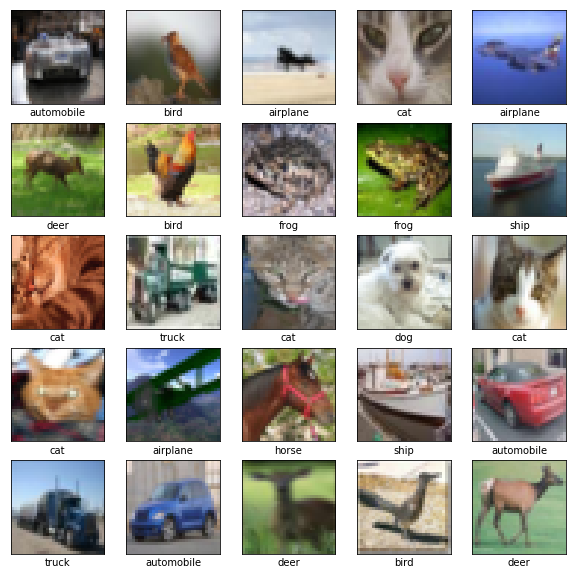

In [13]:
# print(np.argwhere(best_mask!=0).flatten().shape)
# best_idx = np.argwhere(best_mask!=0).flatten()
random_best = np.random.choice(len(new_x_train),25,replace=False)
print(random_outlier)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(new_x_train[random_best[i]], cmap=plt.cm.binary)
#     label = np.argwhere(new_y_train[random_best[i]]==1.0).flatten()[0]
    label = new_y_train[random_best[i]]
    plt.xlabel(cifar10_labels[label])

# 读取data augmentation数据

In [15]:
x_train_augmentation = np.load("../Cifar10_Aug/aug_train_x.npy")

In [16]:
y_train_augmentation = np.load("../Cifar10_Aug/aug_train_y.npy")

# Data Augmentation LID高值

In [18]:
from progressbar import ProgressBar
pbar = ProgressBar()
high_mask=np.zeros(x_train_augmentation.shape[0],dtype=int)
iteration = int(x_train_augmentation.shape[0]/10/batch_size)
dis_high_global = []
for i in pbar(range(iteration)):
    mask=np.random.choice(x_train_augmentation.shape[0],batch_size,True)
    x_batch = x_train_augmentation[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_high_global.extend(dis)
    dis_idx = np.argwhere(dis>np.percentile(dis,90))
    batch_best_mask=mask[dis_idx]
    high_mask[batch_best_mask]+=1

100% |########################################################################|


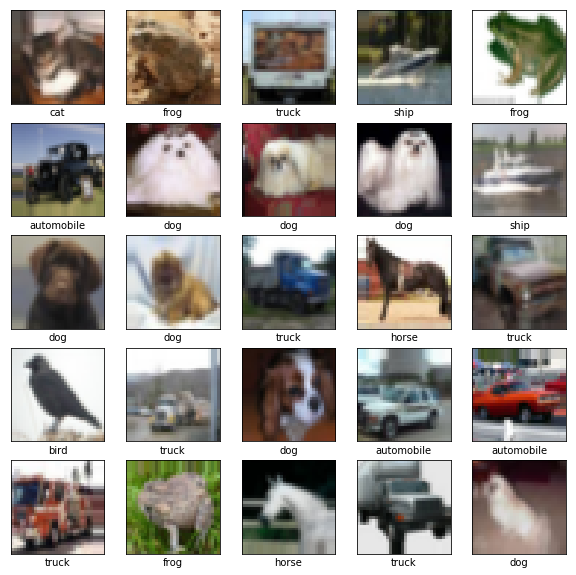

In [19]:
high_idx = np.argwhere(high_mask!=0).flatten()
random_high = np.random.choice(high_idx,25,replace=False)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    tmp = np.asarray(x_train_augmentation[random_high[i]], dtype=np.int)
    plt.imshow(tmp)
    label = y_train_augmentation[random_high[i]][0]
    plt.xlabel(cifar10_labels[label])

# lid分布直方图

(array([  36.,  353., 1116., 1969., 2774., 3219., 3521., 3444., 3343.,
        3089., 2811., 2513., 2210., 1944., 1785., 1615., 1400., 1227.,
        1042.,  994.,  827.,  746.,  726.,  564.,  573.,  506.,  441.,
         389.,  327.,  300.,  284.,  287.,  240.,  209.,  166.,  211.,
         185.,  151.,  172.,  134.,  125.,  121.,   98.,  102.,   84.,
          78.,   91.,   76.,   76.,   76.,   63.,   63.,   51.,   60.,
          37.,   36.,   63.]),
 array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59]),
 <a list of 57 Patch objects>)

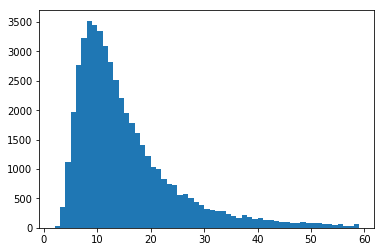

In [20]:
binwidth=1
dis_high_global = np.asarray(dis_high_global, dtype=np.int)
plt.hist(dis_high_global, bins=range(min(dis_high_global), int(max(dis_high_global)/10) + binwidth, binwidth))

# Data Augmentation 随机挑选

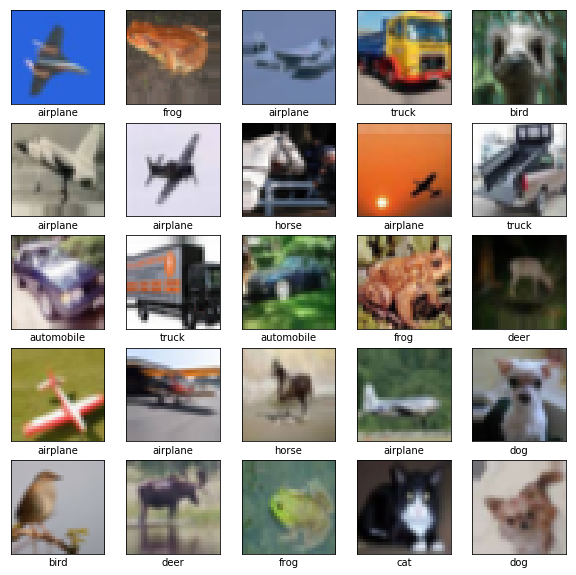

In [21]:
normal_idx = np.random.choice(x_train_augmentation.shape[0],25,replace=False)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    tmp = np.asarray(x_train_augmentation[normal_idx[i]], dtype=np.int)
    plt.imshow(tmp)
    label = y_train_augmentation[normal_idx[i]][0]
    plt.xlabel(cifar10_labels[label])

In [23]:
from progressbar import ProgressBar
pbar = ProgressBar()
iteration = int(x_train_augmentation.shape[0]/10/batch_size)
dis_normal_global = []
for i in pbar(range(iteration)):
    mask=np.random.choice(x_train_augmentation.shape[0],batch_size,True)
    x_batch = x_train_augmentation[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_normal_global.extend(dis)

100% |########################################################################|


# Data Augmentation LID低值

In [25]:
from progressbar import ProgressBar
pbar = ProgressBar()
low_mask=np.zeros(x_train_augmentation.shape[0],dtype=int)
iteration = int(x_train_augmentation.shape[0]/10/batch_size)
dis_low_global = []
for i in pbar(range(iteration)):
    mask=np.random.choice(x_train_augmentation.shape[0],batch_size,True)
    x_batch = x_train_augmentation[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_idx = np.argwhere(dis<np.percentile(dis,10))
    batch_best_mask=mask[dis_idx]
    low_mask[batch_best_mask]+=1

100% |########################################################################|


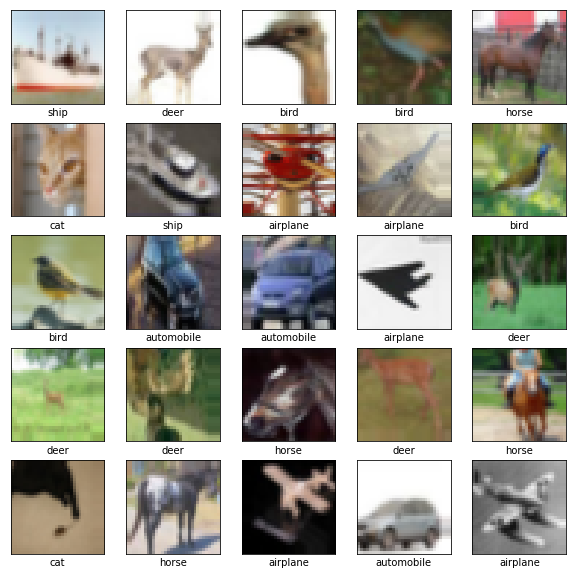

In [26]:
low_idx = np.argwhere(low_mask!=0).flatten()
random_low = np.random.choice(low_idx,25,replace=False)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    tmp = np.asarray(x_train_augmentation[random_low[i]], dtype=np.int)
    plt.imshow(tmp)
    label = y_train_augmentation[random_low[i]][0]
    plt.xlabel(cifar10_labels[label])